In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)

In [2]:
planck_ref = '/Users/sdupourque/PycharmProjects/xcop/data/XCOP/A2142/A2142_y_map_MILCA_070_to_857_GHz_7arcmin.fits'
planck_healpix = 'data/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
#y_hpx = fits.open(planck_healpix)
#hdu = fits.open(planck_ref)[0]
#array, footprint = reproject_from_healpix(y_hpx[1], hdu.header, field='FULL', nested=False, order=0)

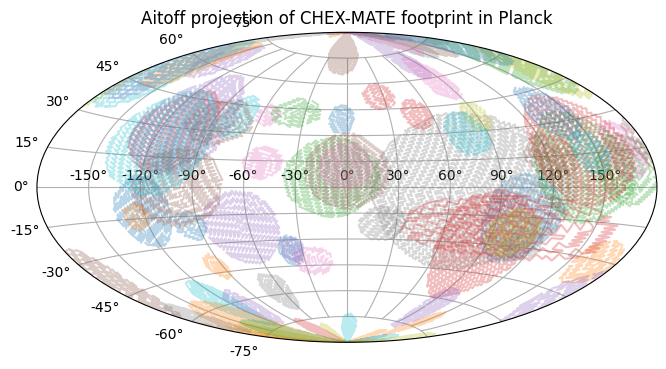

In [3]:
import astropy.units as u
import numpy as np 
from astropy.coordinates import SkyCoord
from astropy.table import Table, QTable
from astropy_healpix import HEALPix
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of CHEX-MATE footprint in Planck")
plt.grid(True)

chexmate_table = Table.read('data/master_chexmate.fits', 1)
hp = HEALPix.from_header(planck_healpix)
y_hp = np.asarray(Table.read(planck_healpix)['FULL'])

def get_data_from_healpix(center, radius):
    
    idx = hp.cone_search_skycoord(center, radius=radius*u.arcmin)
    y_value = np.asarray(y_hp[idx]).astype(float)
    coords = hp.healpix_to_skycoord(idx).transform_to('fk5')
    
    return coords, y_value

for ra, dec, t_500, redshift, m_500 in zip(chexmate_table['RA'], chexmate_table['DEC'], chexmate_table['R500'], chexmate_table['REDSHIFT'], chexmate_table['M500']):
    
    center = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    coords, y_value = get_data_from_healpix(center, 2 * t_500)
    distance = center.separation(coords).to(u.arcmin).value
    plt.plot(coords.ra, coords.dec, markersize=2, alpha=0.3)
    #print(len(y_value))
    
plt.show()

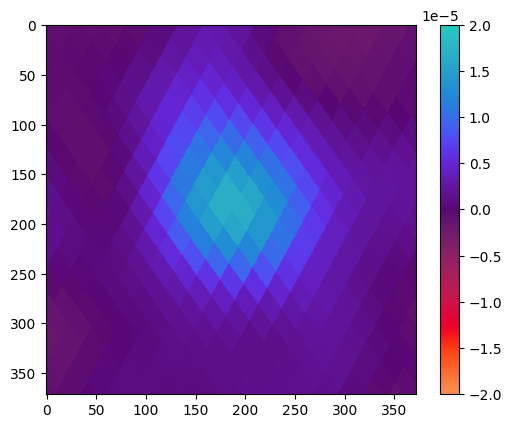

In [4]:
import cmasher as cmr

A2142_coords = SkyCoord(ra=239.58615*u.deg, dec=27.229433*u.deg, frame='icrs')
coords, y_value = get_data_from_healpix(center, 5 * t_500)
distance = center.separation(coords).to(u.arcmin).value

def skygrid(center, width, step):

    width = (width.to(u.arcmin)).value
    step = (step.to(u.arcmin)).value
    skyspan = np.arange(-width, width + step, step)*u.arcmin
    X, Y = np.meshgrid(skyspan, skyspan)
    
    return X, Y, center.spherical_offsets_by(X, Y)

X, Y, offsets = skygrid(center, 5*t_500*u.arcmin, 5*u.arcsec)
y_offsets = y_hp[hp.skycoord_to_healpix(offsets)]

plt.imshow(y_offsets, cmap=cmr.guppy, vmin=-2e-5, vmax=2e-5)
plt.colorbar()
plt.show();

In [5]:
import haiku as hk
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import sigma_T, m_e, c, M_sun
from xsb_fluc.physics.projection import AbelTransform
from haiku.initializers import Constant

cosmo = FlatLambdaCDM(70, 0.3)

class Pressure(hk.Module):
    
    def __init__(self, t_500, m_500):
        
        # t_500 in arcmin, m_500 in 10^14 Msol
        
        super(Pressure, self).__init__()
        self.t_500 = t_500.to(u.arcmin).value
        h70 = float(cosmo.H0/(70*u.km/u.s/u.Mpc))
        self.p_500 = 3.426e-3 * float(m_500 * h70 / (1e15*M_sun)) ** (2/3) * cosmo.efunc(redshift)**(8/3)
        
    
    def __call__(self, r):
        
        p0 = hk.get_parameter("p0", [], init=Constant(5.6))
        c500 = hk.get_parameter("c500", [], init=Constant(1.5))
        alpha = hk.get_parameter("alpha", [], init=Constant(4/3))
        beta = hk.get_parameter("beta", [], init=Constant(4.4))
        gamma = hk.get_parameter("gamma", [], init=Constant(0.5))
        
        x = r / self.t_500
        
        return self.p_500 * p0 /((x*c500)**(gamma)*(1+(x*c500)**alpha)**((beta - gamma)/alpha))


class Ycompton(hk.Module):

    def __init__(self, redshift, t_500, m_500):
        
        super(Ycompton, self).__init__()
        self.pressure = Pressure(t_500, m_500)
        self.projected_pressure = AbelTransform(self.pressure)
        self.r_500 = (t_500/cosmo.arcsec_per_kpc_proper(redshift)).to(u.kpc).value
        self.prefactor = ((sigma_T/(m_e*c**2)).to(u.cm**3 / u.keV / u.kpc)).value
        
    def __call__(self, r):
        
        return self.projected_pressure(r) * self.r_500 * self.prefactor


In [6]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

def bayesian_model(cluster_specs, observable_specs, observed=True):
    
    redshift, t_500, m_500 = cluster_specs
    distance, y_value = observable_specs
    
    func = hk.without_apply_rng(
        hk.transform(lambda r: Ycompton(redshift, t_500, m_500)(r))
    )

    prior = {
        'ycompton/~/pressure':{
            'p0': numpyro.sample("p0", dist.Uniform(0, 14)),
            'c500': numpyro.sample("c500", dist.Uniform(0, 5)),
            'alpha': jnp.asarray(4/3),
            'beta': numpyro.sample("beta", dist.Uniform(2, 8)),
            'gamma': numpyro.sample("gamma", dist.Uniform(0, 0.08)),
        }
    }
    
    y_compton = func.apply(prior, distance)
    
    numpyro.sample('likelihood', dist.Normal(loc=y_compton, scale=1e-7), obs=y_value if observed else None)

In [ ]:
from numpyro.infer import MCMC, NUTS, Predictive
from jax.random import PRNGKey
import arviz as az
import jax

num_samples= 1000
keys = [PRNGKey(0)]

center = A2142_coords
redshift = 0.0909
t_500 = 1424/cosmo.kpc_proper_per_arcmin(redshift).value
m_500 = 8.95
coords, y_value = get_data_from_healpix(center, 3 * t_500)
distance = center.separation(coords).to(u.arcmin).value

cluster_specs = (redshift, t_500*u.arcmin, m_500*1e14*M_sun)
observable_specs = (distance, y_value)

kernel = NUTS(bayesian_model, max_tree_depth=5)
mcmc = MCMC(kernel, num_chains=4, num_warmup=1000, num_samples=num_samples)

keys = jax.random.split(keys[-1], 4)

mcmc.run(keys[0], cluster_specs, observable_specs)
posterior_predictive = Predictive(bayesian_model, mcmc.get_samples())(keys[1], cluster_specs, observable_specs, observed=False)
prior = Predictive(bayesian_model, num_samples=num_samples)(keys[2], cluster_specs, observable_specs, observed=False)
inference_data = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_predictive)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
with az.style.context('arviz-darkgrid'):
    az.plot_trace(inference_data, compact=False,)

In [ ]:
from numpyro.infer import MCMC, NUTS, Predictive
from jax.random import PRNGKey
import arviz as az
import jax

num_samples= 1000
keys = [PRNGKey(0)]

for ra, dec, t_500, redshift, m_500, _ in zip(chexmate_table['RA'], chexmate_table['DEC'], chexmate_table['R500'], chexmate_table['REDSHIFT'], chexmate_table['M500'], range(1)):
    
    center = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    coords, y_value = get_data_from_healpix(center, 2 * t_500)
    distance = center.separation(coords).to(u.arcmin).value
    
    cluster_specs = (redshift, t_500*u.arcmin, m_500*1e14*M_sun)
    observable_specs = (distance, y_value)
    
    kernel = NUTS(bayesian_model, max_tree_depth=8)
    mcmc = MCMC(kernel, num_chains=4, num_warmup=1000, num_samples=num_samples)
    
    keys = jax.random.split(keys[-1], 4)
    
    mcmc.run(keys[0], cluster_specs, observable_specs)
    posterior_predictive = Predictive(bayesian_model, mcmc.get_samples())(keys[1], cluster_specs, observable_specs, observed=False)
    prior = Predictive(bayesian_model, num_samples=num_samples)(keys[2], cluster_specs, observable_specs, observed=False)
    inference_data = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_predictive)

In [ ]:
import arviz as az 

inference_data = az.from_numpyro(mcmc)

In [ ]:
with az.style.context('arviz-darkgrid'):
    az.plot_pair(inference_data)

In [ ]:
with az.style.context('arviz-darkgrid'):
    az.plot_trace(inference_data, compact=False,)

In [ ]:
az.plot_ppc(inference_data);